<h1><center>Reuters-21578 Text Classification</center></h1>
<h3><center>Unsupervised Learning Capstone, Thinkful Data Science Bootcamp</center></h3>
<h3><center>Brian McGuckin</center></h3>

Article category classification using the Reuters-21578 text categorization test collection; a resource for research in information retrieval, machine learning, and other corpus-based research.

Concepts & methods used in this project include:
- Unsupervised & supervised machine learning algorithms
- Unsupervised feature generation
- Text cleaning, preparation, tokenization and vectorization
- Dimensionality reduction techniques

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re

import time
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# 1.1 Import, inspect, & prepare data

The corpus used for this project is the Reuters-21578 dataset, which is pre-loaded into nltk with category labels applied to each article (some having more than one label). This notebook entails processing the data, splitting it into a couple different classification tasks, and using some unsupervised feature generation and clustering techniques to see how well they can classify the articles they're given. Then the same data is given to some supervised classification models to see how they perform with it. Finally, a new-to-me dimensionality reduction technique called UMAP is employed and results compared to the rest of the notebook.

In [3]:
from nltk.corpus import reuters, stopwords

#each file is pre-labeled for train (~73%) and test (remaining 27%)
train_files = list(filter(lambda x: x.startswith('training'), reuters.fileids()))
test_files = list(filter(lambda x: x.startswith('test'), reuters.fileids()))

print(train_files[:3])
print(test_files[:3])
print(len(train_files))
print(len(test_files))

['training/1', 'training/10', 'training/100']
['test/14826', 'test/14828', 'test/14829']
7769
3019


In [4]:
#see what this data looks like
train_raw = reuters.raw(train_files)
test_raw = reuters.raw(test_files)

print(train_raw[:500])

BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at th


In [5]:
#text cleaning function
def text_cleaner(text):
    text = re.sub(r'--',' ', text) #double hyphens cause problems
    text = re.sub('[^A-Za-z0-9]+', ' ', text) #matches characters that are not letters or numbers
    text = re.sub(r'\d+','', text) #this handles digits
    
    #comparison operators format weird
    text = re.sub(r'&lt;', ' ', text)
    text = re.sub(r'&gt;', ' ', text)
    text = re.sub(r'&le;', ' ', text)
    text = re.sub(r'&ge;', ' ', text)
    
    #lowercase and join
    text = text.lower()
    text = ' '.join(text.split())
    return text

In [6]:
#populate train df
train_df = pd.DataFrame()
for file in train_files:
    if len(reuters.categories(file)) == 1:
        train_df = train_df.append({
            'category':''.join(reuters.categories(file)),
            'fileid':file,
            'text':text_cleaner(reuters.raw([file]))}, ignore_index=True)

#inspect results        
print('\n{} train files; data shape is {}'.format(
    len(train_files), train_df.shape))
print('articles eliminated: {}\n'.format(len(train_files) - len(train_df)))
print('dataframe head: \n{}'.format(train_df.head()))

#populate test df
test_df = pd.DataFrame()
for file in test_files:
    if len(reuters.categories(file)) == 1:
        test_df = test_df.append({
            'category':''.join(reuters.categories(file)),
            'fileid':file,
            'text':text_cleaner(reuters.raw(file))}, ignore_index=True)

#inspect results
print('\n{} test files; data shape is {}'.format(len(
    test_files), test_df.shape))
print('articles eliminated: {}\n'.format(len(test_files) - len(test_df)))
print('dataframe head: \n{}'.format(test_df.head()))


7769 train files; data shape is (6577, 3)
articles eliminated: 1192

dataframe head: 
       category          fileid  \
0         cocoa      training/1   
1           acq     training/10   
2  money-supply    training/100   
3           acq   training/1000   
4          earn  training/10000   

                                                text  
0  bahia cocoa review showers continued throughou...  
1  computer terminal systems lt cpml completes sa...  
2  n z trading bank deposit growth rises slightly...  
3  national amusements again ups viacom lt via bi...  
4  rogers lt rog sees st qtr net up significantly...  

3019 test files; data shape is (2583, 3)
articles eliminated: 436

dataframe head: 
  category      fileid                                               text
0    trade  test/14826  asian exporters fear damage from u s japan rif...
1    grain  test/14828  china daily says vermin eat pct grain stocks a...
2     ship  test/14839  australian foreign ship ban ends but nsw 

In [7]:
#combine dfs, will do train/test split later
df = pd.concat([train_df, test_df], 0).reset_index()

### Categories for classification

Since there are 90 different categories articles are labeled with, many with only a handful of articles in each category, focus is on 2 sets of the top categories.
- 1st set: earn & acq
- 2nd set: crude, trade, & money-fx

In [8]:
#narrow focus on a few top categories
print('top categories:\n{}'.format(df['category'].value_counts()[:10]))

top categories:
earn            3923
acq             2292
crude            374
trade            326
money-fx         309
interest         272
money-supply     151
ship             144
sugar            122
coffee           112
Name: category, dtype: int64


In [9]:
#separate classes to focus on
df_earn = df.loc[df['category'] == 'earn']
df_acq = df.loc[df['category'] == 'acq']
df_crude = df.loc[df['category'] == 'crude']
df_trade = df.loc[df['category'] == 'trade']
df_money = df.loc[df['category'] == 'money-fx']

from sklearn.model_selection import train_test_split

#set data/target for classes
X_train_earn, X_test_earn, y_train_earn, y_test_earn = train_test_split(
    df_earn['text'], df_earn['category'], test_size=0.25)

X_train_acq, X_test_acq, y_train_acq, y_test_acq = train_test_split(
    df_acq['text'], df_acq['category'], test_size=0.25)

X_train_crude, X_test_crude, y_train_crude, y_test_crude = train_test_split(
    df_crude['text'], df_crude['category'], test_size=0.25)

X_train_trade, X_test_trade, y_train_trade, y_test_trade = train_test_split(
    df_trade['text'], df_trade['category'], test_size=0.25)

X_train_money, X_test_money, y_train_money, y_test_money = train_test_split(
    df_money['text'], df_money['category'], test_size=0.25)

#earn vs acq
X_train = pd.concat([X_train_earn, X_train_acq])
X_test = pd.concat([X_test_earn, X_test_acq])
y_train = pd.concat([y_train_earn, y_train_acq])
y_test = pd.concat([y_test_earn, y_test_acq])

#crude vs trade vs money
X_train_ = pd.concat([X_train_crude, X_train_trade, X_train_money])
X_test_ = pd.concat([X_test_crude, X_test_trade, X_test_money])
y_train_ = pd.concat([y_train_crude, y_train_trade, y_train_money])
y_test_ = pd.concat([y_test_crude, y_test_trade, y_test_money])

In [10]:
#verify class ratio between train & test sets
print('earn/acq train class balance: {:0.05}'.format(
    y_train.value_counts()[1]/y_train.value_counts().sum()))
print('earn/acq test class balance: {:0.05}'.format(
    y_test.value_counts()[1]/y_test.value_counts().sum()))

print('trade/crude/money train class balance: {:0.05}'.format(
    y_train_.value_counts()[1]/y_train_.value_counts().sum()))
print('trade/crude/money test class balance: {:0.05}'.format(
    y_test_.value_counts()[1]/y_test_.value_counts().sum()))

earn/acq train class balance: 0.3688
earn/acq test class balance: 0.36873
trade/crude/money train class balance: 0.32318
trade/crude/money test class balance: 0.32283


# 1.2 Feature generation using tf-idf vectorization

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2,
                             stop_words='english',
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

### Vectors for earn & acq class set

In [12]:
#train vectors
X_train_tfidf = vectorizer.fit_transform(X_train)
print('train features: {}'.format(X_train_tfidf.get_shape()[1]))

#test vectors
X_test_tfidf = vectorizer.fit_transform(X_test)
print('test features: {}'.format(X_test_tfidf.get_shape()[1]))

train features: 7763
test features: 3894


### Vectors for crude, trade, and money-fx set
- Note: to keep code readable, these variables are named the same as the earn/acq variables, with the addition of a trailing underscore

In [13]:
#train vectors
X_train_tfidf_ = vectorizer.fit_transform(X_train_)
print('train features: {}'.format(X_train_tfidf_.get_shape()[1]))

#test vectors
X_test_tfidf_ = vectorizer.fit_transform(X_test_)
print('test features: {}'.format(X_test_tfidf_.get_shape()[1]))

train features: 4515
test features: 2493


# 2 Modeling, tf-idf feature set
## 2.1 Clustering, 2 classes

In [14]:
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

X_train_norm = normalize(X_train_tfidf)
X_test_norm = normalize(X_test_tfidf)

X_train_svd = TruncatedSVD(2).fit_transform(X_train_norm)
X_test_svd = TruncatedSVD(2).fit_transform(X_test_norm)

n_clust = 2

### Ground Truth
Since labels are known, ground truth can be visualized and adjusted rand index will be the primary evaluation metric (as simply looking at 2d representations of high dimensional data is not completely accurate)

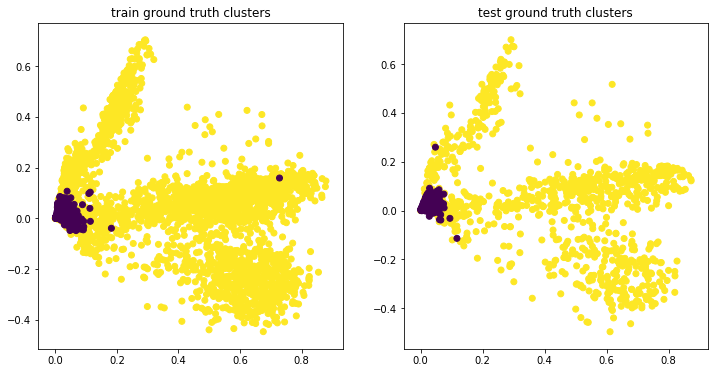

In [15]:
y_train_gt = pd.Categorical(y_train).codes
y_test_gt = pd.Categorical(y_test).codes

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_gt)
plt.title('train ground truth clusters')

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=y_test_gt)
plt.title('test ground truth clusters')

plt.show()

### k-means & MiniBatchKMeans

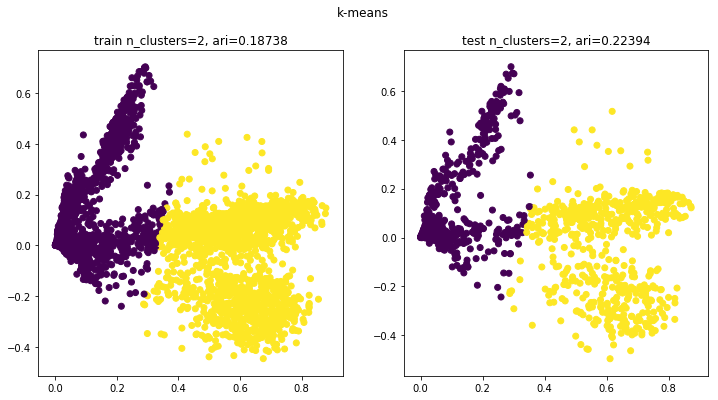

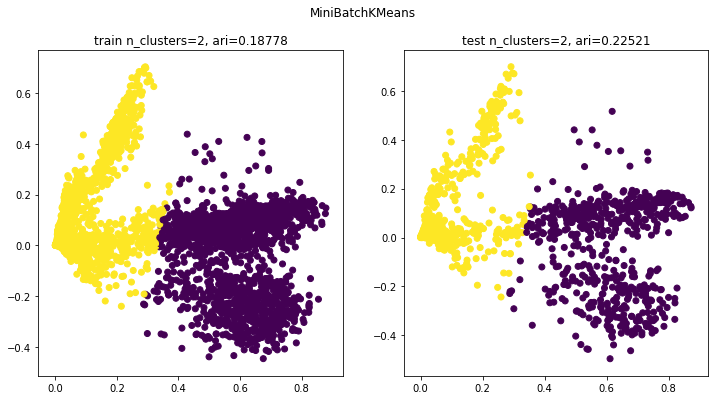

In [16]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix

#k-means code
kmeans = KMeans(n_clusters=n_clust,
                init='k-means++',
                n_init=10)

y_pred_train = kmeans.fit_predict(X_train_svd)
y_pred_test = kmeans.predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('k-means')
plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, y_pred_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=y_pred_test)
plt.title('test n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_test, y_pred_test)))

plt.show()

#minibatch code
mbkmeans = MiniBatchKMeans(init='random',
                           n_clusters=n_clust,
                           batch_size=100).fit(X_train_svd)

predict_mini_train = mbkmeans.predict(X_train_svd)
predict_mini_test = mbkmeans.predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('MiniBatchKMeans')
plt.subplot(121)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=predict_mini_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, predict_mini_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_mini_test)
plt.title('test n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_test, predict_mini_test)))
plt.show()

**Result:** both full and mini batch k-means algorithms perform better than random at assigning points to clusters, but are both still relatively far off from the ground truth clusters. On a positive note, these algorithms do tend to produce consistent clusters.

### Spectral Clustering
The main parameter in spectral clustering (aside from n_clusters) is the affinity parameter, which is user set similarity function for  the algorithm to use.
- Kernels used in the project:
    - rbf (default)
    - sigmoid
    - neareest neighbors

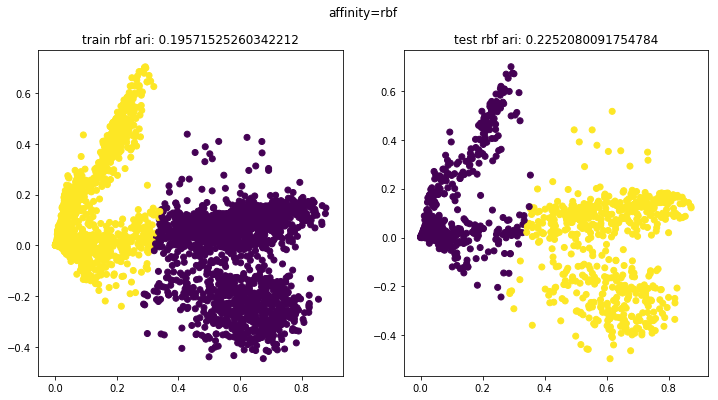

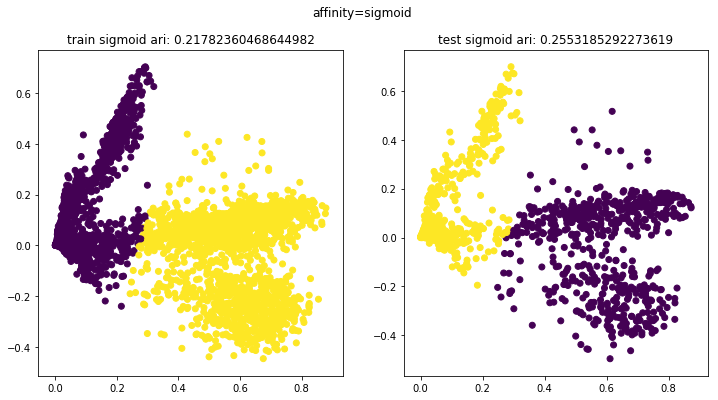

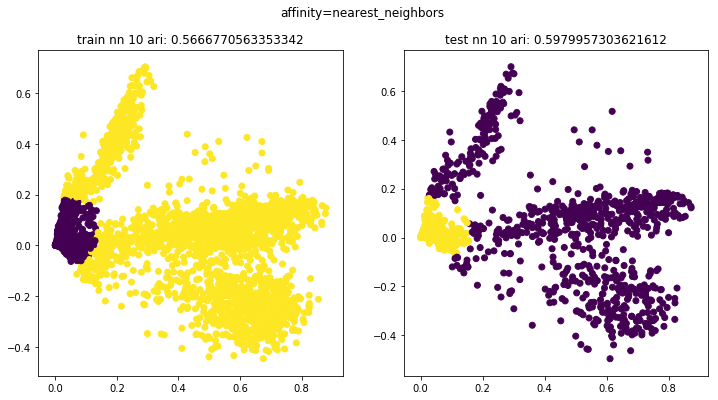

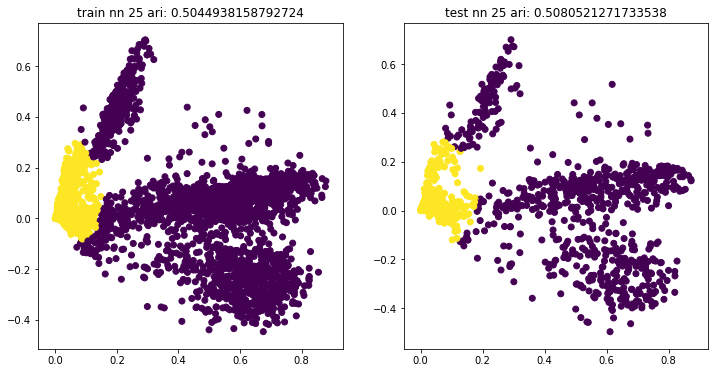

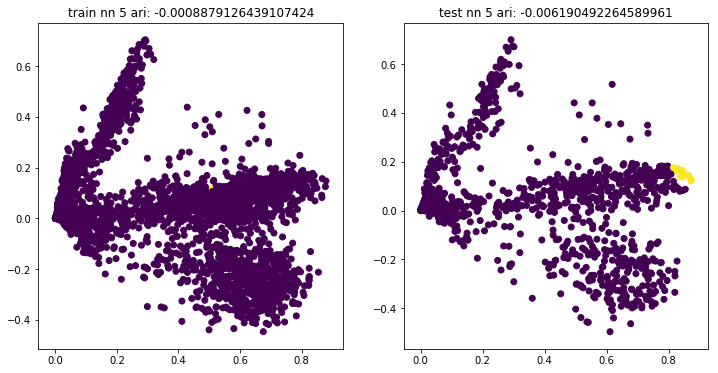

In [17]:
from sklearn.cluster import SpectralClustering

#rbf
sc_rbf = SpectralClustering(n_clusters=n_clust,
                            affinity='rbf').fit(X_train_svd)

predict_rbf_train = sc_rbf.fit_predict(X_train_svd)
predict_rbf_test = sc_rbf.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=rbf')
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_rbf_train)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y_train, predict_rbf_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_rbf_test)
plt.title('test rbf ari: {}'.format(
    adjusted_rand_score(y_test, predict_rbf_test)))
plt.show()

#sigmoid
sc_sig = SpectralClustering(n_clusters=n_clust,
                            affinity='sigmoid').fit(X_train_svd)

predict_sig_train = sc_sig.fit_predict(X_train_svd)
predict_sig_test = sc_sig.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=sigmoid')
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_sig_train)
plt.title('train sigmoid ari: {}'.format(adjusted_rand_score(
    y_train, predict_sig_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_sig_test)
plt.title('test sigmoid ari: {}'.format(
    adjusted_rand_score(y_test, predict_sig_test)))
plt.show()

#nearest neighbors = 10 (default)
sc_nn10 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_svd)

predict_nn10_train = sc_nn10.fit_predict(X_train_svd)
predict_nn10_test = sc_nn10.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=nearest_neighbors')
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn10_train)
plt.title('train nn 10 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn10_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_nn10_test)
plt.title('test nn 10 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn10_test)))
plt.show()

#nearest neighbors = 25
sc_nn25 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=25).fit(X_train_svd)

predict_nn25_train = sc_nn25.fit_predict(X_train_svd)
predict_nn25_test = sc_nn25.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn25_train)
plt.title('train nn 25 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn25_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_nn25_test)
plt.title('test nn 25 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn25_test)))
plt.show()

#nearest neighbors = 5
sc_nn5 = SpectralClustering(n_clusters=n_clust,
                            affinity='nearest_neighbors',
                            n_neighbors=5).fit(X_train_svd)

predict_nn5_train = sc_nn5.fit_predict(X_train_svd)
predict_nn5_test = sc_nn5.fit_predict(X_test_svd)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=predict_nn5_train)
plt.title('train nn 5 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn5_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=predict_nn5_test)
plt.title('test nn 5 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn5_test)))
plt.show()

**Result:** spectral clustering is very dependent on which similarity function it's using. Rbf (default) and sigmoid produce slightly better better ARI scores than k-means. Nearest neighbors shows a lot of promise in terms of agreement with ground truth clusters, but also exhibits large amounts of variance not only between different values of n_neighbors, but also between train & test sets for the same n_neighbors value.

Next up are clustering algorithms that do not take a user defined value for number of clusters - these decide how many clusters to generate based on their own interpretation of the data

### Mean-shift

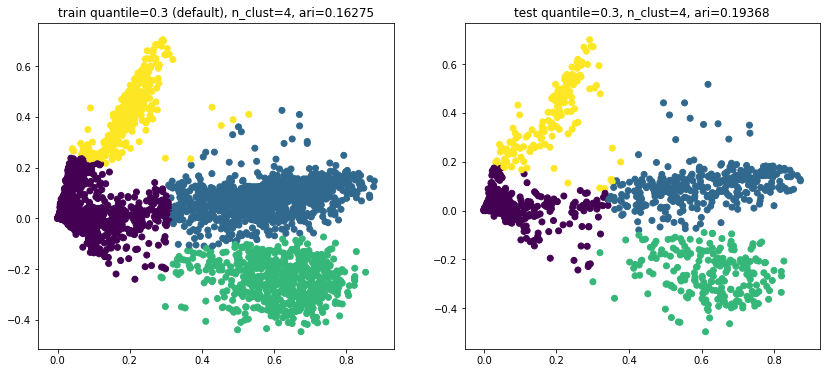

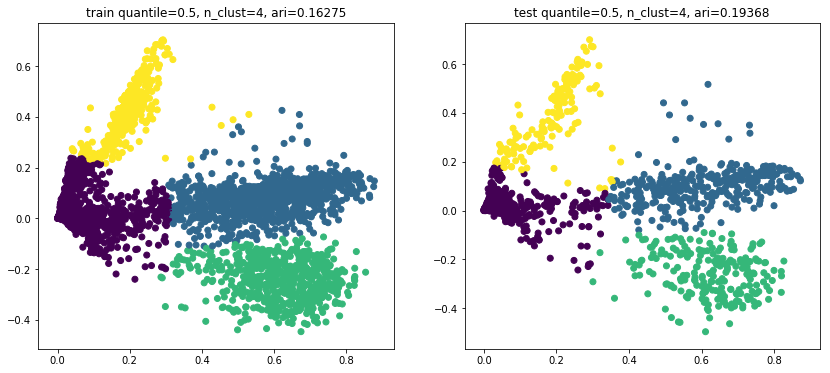

In [18]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_train_svd, quantile=0.3)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms_train = ms.fit_predict(X_train_svd)
n_clusters_train = len(np.unique(ms_train))

ms_test = ms.fit_predict(X_test_svd)
n_clusters_test = len(np.unique(ms_test))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=ms_train)
plt.title('train quantile=0.3 (default), n_clust={}, ari={:0.5}'.format(
    n_clusters_train, adjusted_rand_score(y_train, ms_train)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=ms_test)
plt.title('test quantile=0.3, n_clust={}, ari={:0.5}'.format(
    n_clusters_test, adjusted_rand_score(y_test, ms_test)))

plt.show()

#try other values for quantile parameter in bandwidth
bandwidth2 = estimate_bandwidth(X_train_svd, quantile=0.5)
ms2 = MeanShift(bandwidth=bandwidth, bin_seeding=True)

ms_train2 = ms2.fit_predict(X_train_svd)
n_clusters_train2 = len(np.unique(ms_train2))

ms_test2 = ms2.fit_predict(X_test_svd)
n_clusters_test2 = len(np.unique(ms_test2))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.scatter(X_train_svd[:,0], X_train_svd[:,1], c=ms_train2)
plt.title('train quantile=0.5, n_clust={}, ari={:0.5}'.format(
    n_clusters_train2, adjusted_rand_score(y_train, ms_train2)))

plt.subplot(122)
plt.scatter(X_test_svd[:,0], X_test_svd[:,1], c=ms_test)
plt.title('test quantile=0.5, n_clust={}, ari={:0.5}'.format(
    n_clusters_test2, adjusted_rand_score(y_test, ms_test2)))

plt.show()

### Affinity propagation

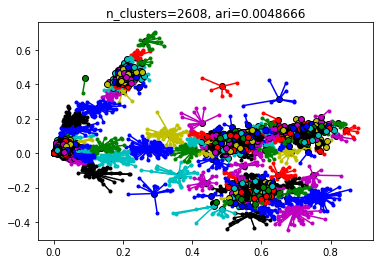

In [19]:
from sklearn.cluster import AffinityPropagation
from itertools import cycle

af = AffinityPropagation()
af_pred = af.fit_predict(X_train_svd)

cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train_svd[cluster_centers_indices[k]]
    plt.plot(
        X_train_svd[class_members, 0],
        X_train_svd[class_members, 1],
        col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train_svd[class_members]:
        plt.plot([cluster_center[0], x[0]],
                 [cluster_center[1], x[1]],
                 col)

plt.title('n_clusters={}, ari={:0.5}'.format(
    n_clusters_, adjusted_rand_score(y_train, af_pred)))
plt.show()

**Result:** Both of these algorithms perform quite poorly. While mean-shift will occasionally produce the correct amount of clusters, it's highly inconsistent and will often generate a different number of clusters upon each iteration, even within a given set of parameters. Affinity propagation not only is the slowest algorithm to run, but it also generates a ridiculous solution with thousands of clusters and ARI scores indicating it is no better than random assignment. Moving forward neither of these algorithms will be revisited.

## 2.2 Supervised classifiers, 2 classes

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier().fit(X_train_tfidf, y_train)

print('vanilla KNN classifier')
print('train 10 cv mean: {}'.format(cross_val_score(knn, X_train_tfidf, y_train, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(knn, X_test_tfidf, y_test, cv=10).mean()))

vanilla KNN classifier
train 10 cv mean: 0.9043036939952012
test 10 cv mean: 0.9124642674632402


In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train_tfidf, y_train)

print('vanilla logistic regression')
print('train 10 cv mean: {}'.format(cross_val_score(lr, X_train_tfidf, y_train, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(lr, X_test_tfidf, y_test, cv=10).mean()))

vanilla logistic regression
train 10 cv mean: 0.9761852923827771
test 10 cv mean: 0.9671584928324192


In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier().fit(X_train_tfidf, y_train)

print('vanilla random forest classifier')
print('train 10 cv mean: {}'.format(cross_val_score(rfc, X_train_tfidf, y_train, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(rfc, X_test_tfidf, y_test, cv=10).mean()))

vanilla random forest classifier
train 10 cv mean: 0.963314341143759
test 10 cv mean: 0.9517282272552461


In [23]:
import xgboost as xgb
xgbc = xgb.XGBClassifier().fit(X_train_tfidf, y_train)

print('vanilla xgboost classifier')
print('train 10 cv mean: {}'.format(cross_val_score(xgbc, X_train_tfidf, y_train, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(xgbc, X_test_tfidf, y_test, cv=10).mean()))

vanilla xgboost classifier
train 10 cv mean: 0.9748954352436894
test 10 cv mean: 0.9697679294884967


**Result:** even without tuning any parameters, these classifiers all perform quite well and produce favorable results compared to the clustering algorithms. XGBoost and logistic regression are particularly effective at classifying this data.

## 2.3 Clustering, 3 classes

In [24]:
X_train_norm_ = normalize(X_train_tfidf_)
X_test_norm_ = normalize(X_test_tfidf_)

X_train_svd_ = TruncatedSVD(2).fit_transform(X_train_norm_)
X_test_svd_ = TruncatedSVD(2).fit_transform(X_test_norm_)

n_clust_ = 3

### Ground Truth

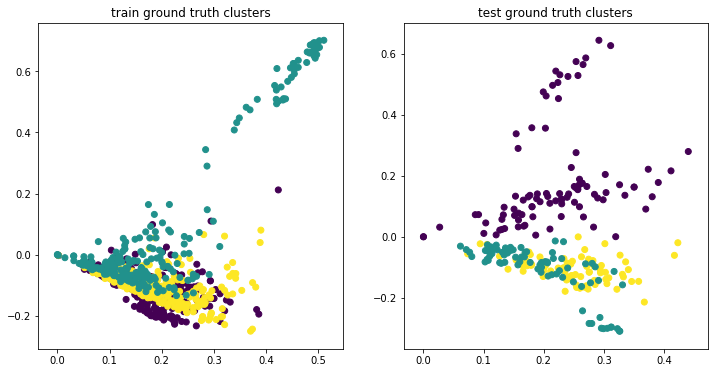

In [25]:
y_train_gt_ = pd.Categorical(y_train_).codes
y_test_gt_ = pd.Categorical(y_test_).codes

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:, 0], X_train_svd_[:, 1], c=y_train_gt_)
plt.title('train ground truth clusters')

plt.subplot(122)
plt.scatter(X_test_svd_[:, 0], X_test_svd_[:, 1], c=y_test_gt_)
plt.title('test ground truth clusters')
plt.show()

While these plots are an oversimplified representation of the ground truth clusters, these classes appear to less clearly defined in comparison to the earn/acq dataset.

### k-means

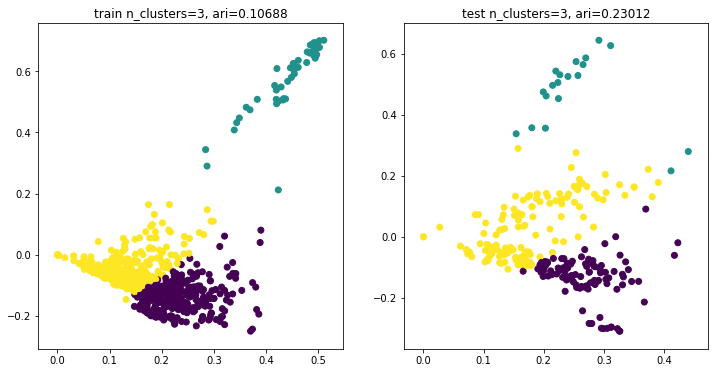

In [26]:
kmeans_ = KMeans(n_clusters=n_clust_,
                 init='k-means++',
                 n_init=10).fit(X_train_svd_)

y_pred_train_ = kmeans_.predict(X_train_svd_)
y_pred_test_ = kmeans_.predict(X_test_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:, 0], X_train_svd_[:, 1], c=y_pred_train_)
plt.title('train n_clusters=3, ari={:0.5}'.format(
    adjusted_rand_score(y_train_, y_pred_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=y_pred_test_)
plt.title('test n_clusters=3, ari={:0.5}'.format(
    adjusted_rand_score(y_test_, y_pred_test_)))
plt.show()

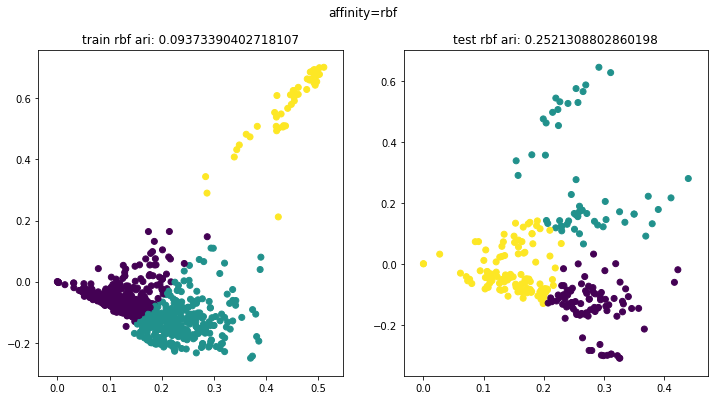

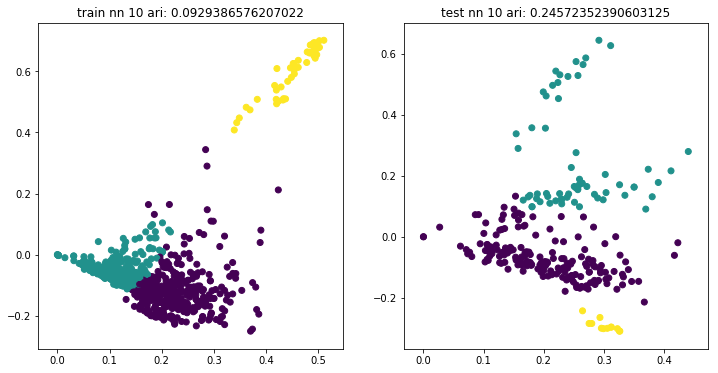

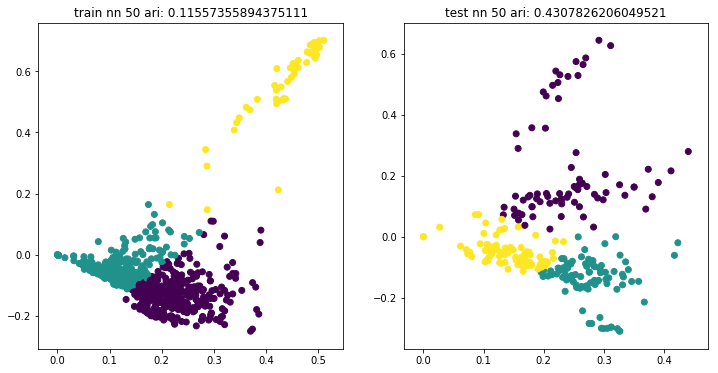

In [27]:
#rbf
sc_rbf_ = SpectralClustering(n_clusters=n_clust_,
                            affinity='rbf').fit(X_train_svd_)

predict_rbf_train_ = sc_rbf_.fit_predict(X_train_svd_)
predict_rbf_test_ = sc_rbf_.fit_predict(X_test_svd_)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=rbf')
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_rbf_train_)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y_train_, predict_rbf_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=predict_rbf_test_)
plt.title('test rbf ari: {}'.format(
    adjusted_rand_score(y_test_, predict_rbf_test_)))
plt.show()

#nearest neighbors = 10
sc_nn10_ = SpectralClustering(n_clusters=n_clust_,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_svd_)

predict_nn10_train_ = sc_nn10_.fit_predict(X_train_svd_)
predict_nn10_test_ = sc_nn10_.fit_predict(X_test_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_nn10_train_)
plt.title('train nn 10 ari: {}'.format(adjusted_rand_score(
    y_train_, predict_nn10_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=predict_nn10_test_)
plt.title('test nn 10 ari: {}'.format(
    adjusted_rand_score(y_test_, predict_nn10_test_)))
plt.show()

#nearest neighbors = 50
sc_nn50_ = SpectralClustering(n_clusters=n_clust_,
                            affinity='nearest_neighbors',
                            n_neighbors=50).fit(X_train_svd_)

predict_nn50_train_ = sc_nn50_.fit_predict(X_train_svd_)
predict_nn50_test_ = sc_nn50_.fit_predict(X_test_svd_)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_svd_[:,0], X_train_svd_[:,1], c=predict_nn50_train_)
plt.title('train nn 50 ari: {}'.format(adjusted_rand_score(
    y_train_, predict_nn50_train_)))

plt.subplot(122)
plt.scatter(X_test_svd_[:,0], X_test_svd_[:,1], c=predict_nn50_test_)
plt.title('test nn 50 ari: {}'.format(
    adjusted_rand_score(y_test_, predict_nn50_test_)))
plt.show()

**Results:** perhaps due to the peculiarities of the 3 class data and their overlapping characteristics, these algorithms are much less capable this time around. Especially concerning is the vast difference in ARI scores between train and test sets, where the test set is actually much higher than the train set. Some randomness of the train_test_split for this iteration may have an effect here, even though the results of that do result in equivalent class ratios (as shown in the first section)

## 2.4 Supervised classifiers, 3 classes

In [28]:
knn_ = KNeighborsClassifier().fit(X_train_tfidf_, y_train_)

print('vanilla KNN classifier')
print('train 10 cv mean: {}'.format(cross_val_score(knn_, X_train_tfidf_, y_train_, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(knn_, X_test_tfidf_, y_test_, cv=10).mean()))

vanilla KNN classifier
train 10 cv mean: 0.9457188425609478
test 10 cv mean: 0.8231937321937322


In [29]:
lr_ = LogisticRegression().fit(X_train_tfidf_, y_train_)

print('vanilla logistic regression')
print('train 10 cv mean: {}'.format(cross_val_score(lr_, X_train_tfidf_, y_train_, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(lr_, X_test_tfidf_, y_test_, cv=10).mean()))

vanilla logistic regression
train 10 cv mean: 0.9787368421052631
test 10 cv mean: 0.9687464387464388


In [30]:
rfc_ = RandomForestClassifier().fit(X_train_tfidf_, y_train_)

print('vanilla random forest classifier')
print('train 10 cv mean: {}'.format(cross_val_score(rfc_, X_train_tfidf_, y_train_, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(rfc_, X_test_tfidf_, y_test_, cv=10).mean()))

vanilla random forest classifier
train 10 cv mean: 0.9377350193665984
test 10 cv mean: 0.8945541310541308


In [31]:
xgbc_ = xgb.XGBClassifier().fit(X_train_tfidf_, y_train_)

print('vanilla xgboost classifier')
print('train 10 cv mean: {}'.format(cross_val_score(xgbc_, X_train_tfidf_, y_train_, cv=10).mean()))
print('test 10 cv mean: {}'.format(cross_val_score(xgbc_, X_test_tfidf_, y_test_, cv=10).mean()))

vanilla xgboost classifier
train 10 cv mean: 0.96822670312144
test 10 cv mean: 0.9404245014245014


**Result:** Again, these classification algorithms are much superior to clustering when it comes to classifying this  data. They do tend to exhibit some overfitting which could be mitigated with some parameter tuning, but even in vanilla form they are much more consistent between train/test sets, which seemed to throw off the clustering algorithms.

## 2.5 UMAP dimension reduction for clustering

UMAP stands for Uniform Manifold Approximation and Projection, and is useful for visualization and non-linear dimension reduction. This is my first time experimenting with this technique, so all this section will entail is getting some baseline results from UMAP and some light parameter tuning.

In [32]:
import umap

reducer = umap.UMAP()
X_train_umap = reducer.fit_transform(X_train_norm)
X_test_umap = reducer.fit_transform(X_test_norm)
print(X_train_umap.shape)
print(X_test_umap.shape)

(4661, 2)
(1554, 2)


### Ground Truth

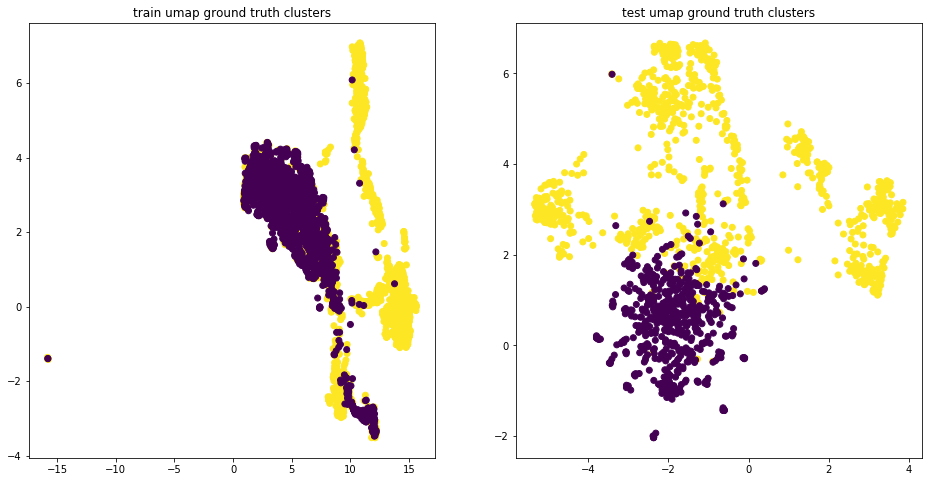

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train_gt)
plt.title('train umap ground truth clusters')

plt.subplot(122)
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test_gt)
plt.title('test umap ground truth clusters')
plt.show()

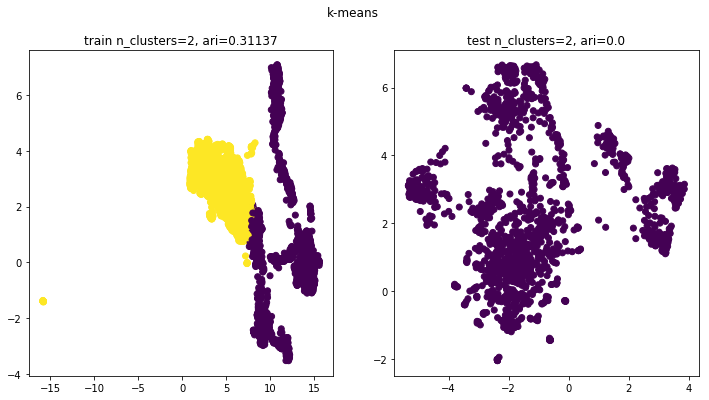

In [34]:
#k-means code
kmeans = KMeans(n_clusters=n_clust,
                init='k-means++',
                n_init=10)

y_pred_train = kmeans.fit_predict(X_train_umap)
y_pred_test = kmeans.predict(X_test_umap)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('k-means')
plt.subplot(121)
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_pred_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, y_pred_train)))

plt.subplot(122)
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_pred_test)
plt.title('test n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_test, y_pred_test)))

plt.show()

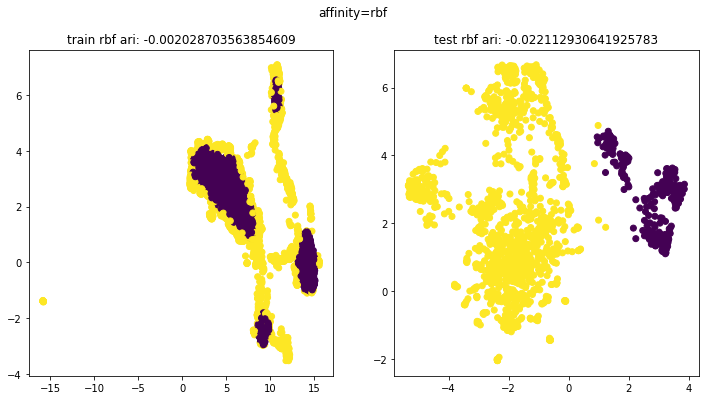

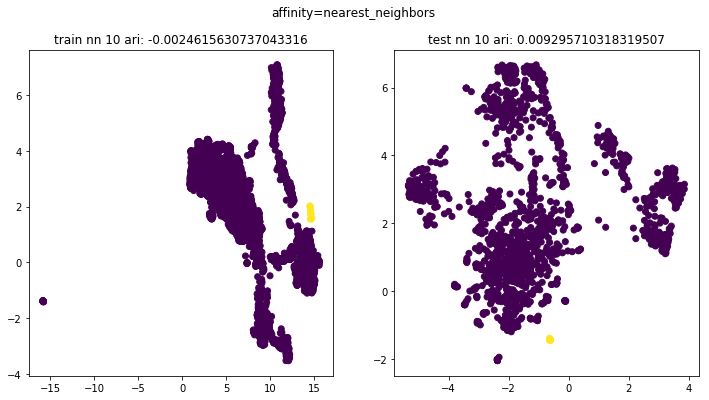

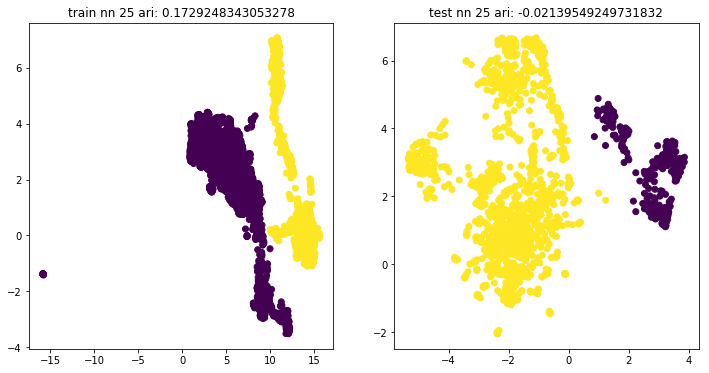

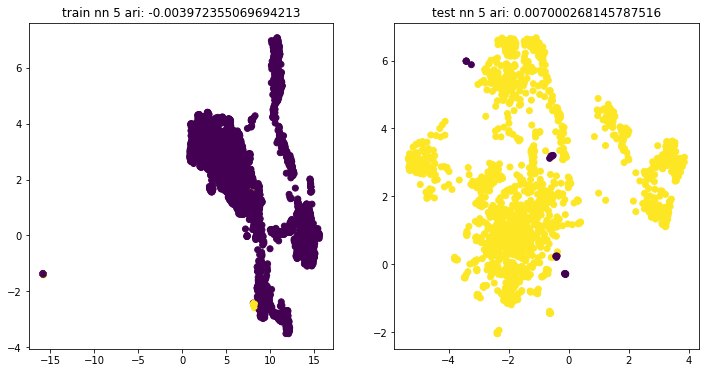

In [35]:
#rbf
sc_rbf = SpectralClustering(n_clusters=n_clust,
                            affinity='rbf').fit(X_train_umap)

predict_rbf_train = sc_rbf.fit_predict(X_train_umap)
predict_rbf_test = sc_rbf.fit_predict(X_test_umap)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=rbf')
plt.subplot(121)
plt.scatter(X_train_umap[:,0], X_train_umap[:,1], c=predict_rbf_train)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y_train, predict_rbf_train)))

plt.subplot(122)
plt.scatter(X_test_umap[:,0], X_test_umap[:,1], c=predict_rbf_test)
plt.title('test rbf ari: {}'.format(
    adjusted_rand_score(y_test, predict_rbf_test)))
plt.show()

#nearest neighbors = 10 (default)
sc_nn10 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=10).fit(X_train_umap)

predict_nn10_train = sc_nn10.fit_predict(X_train_umap)
predict_nn10_test = sc_nn10.fit_predict(X_test_umap)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('affinity=nearest_neighbors')
plt.subplot(121)
plt.scatter(X_train_umap[:,0], X_train_umap[:,1], c=predict_nn10_train)
plt.title('train nn 10 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn10_train)))

plt.subplot(122)
plt.scatter(X_test_umap[:,0], X_test_umap[:,1], c=predict_nn10_test)
plt.title('test nn 10 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn10_test)))
plt.show()

#nearest neighbors = 25
sc_nn25 = SpectralClustering(n_clusters=n_clust,
                             affinity='nearest_neighbors',
                             n_neighbors=25).fit(X_train_umap)

predict_nn25_train = sc_nn25.fit_predict(X_train_umap)
predict_nn25_test = sc_nn25.fit_predict(X_test_umap)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_umap[:,0], X_train_umap[:,1], c=predict_nn25_train)
plt.title('train nn 25 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn25_train)))

plt.subplot(122)
plt.scatter(X_test_umap[:,0], X_test_umap[:,1], c=predict_nn25_test)
plt.title('test nn 25 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn25_test)))
plt.show()

#nearest neighbors = 5
sc_nn5 = SpectralClustering(n_clusters=n_clust,
                            affinity='nearest_neighbors',
                            n_neighbors=5).fit(X_train_umap)

predict_nn5_train = sc_nn5.fit_predict(X_train_umap)
predict_nn5_test = sc_nn5.fit_predict(X_test_umap)

#plots
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(X_train_umap[:,0], X_train_umap[:,1], c=predict_nn5_train)
plt.title('train nn 5 ari: {}'.format(adjusted_rand_score(
    y_train, predict_nn5_train)))

plt.subplot(122)
plt.scatter(X_test_umap[:,0], X_test_umap[:,1], c=predict_nn5_test)
plt.title('test nn 5 ari: {}'.format(
    adjusted_rand_score(y_test, predict_nn5_test)))
plt.show()

**Result:** clustering algorithms struggled with data transformed by untuned UMAP dimension reduction, ARI scores indicate cluster assignments are rarely much better than random assignment

### UMAP parameter tuning

Parameters:
- n_neighbors, min_dist: little to no effect on this data
- metric: euclidean (no effect), manhattan (), cosine (no effect), hamming (error sparse distances), jaccard (sparse distances)

In [36]:
reducer_ = umap.UMAP(n_neighbors=20, metric='cosine')
X_train_umap_ = reducer_.fit_transform(X_train_norm)
X_test_umap_ = reducer_.fit_transform(X_test_norm)
print(X_train_umap_.shape)
print(X_test_umap_.shape)

(4661, 2)
(1554, 2)


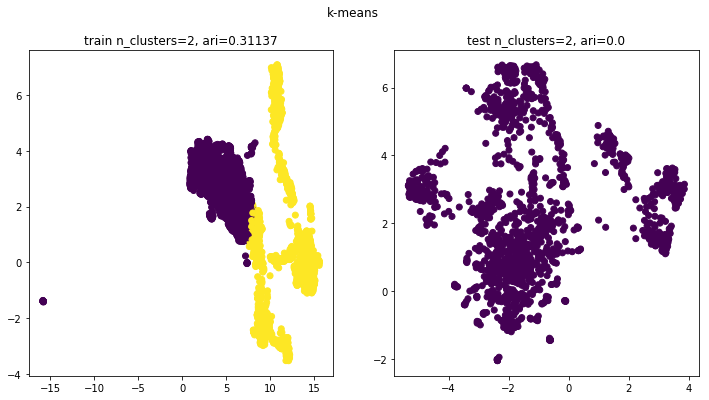

In [37]:
#k-means code
kmeans = KMeans(n_clusters=n_clust,
                init='k-means++',
                n_init=10)

y_pred_train = kmeans.fit_predict(X_train_umap)
y_pred_test = kmeans.predict(X_test_umap)

#plots
plt.figure(figsize=(12,6))
plt.suptitle('k-means')
plt.subplot(121)
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_pred_train)
plt.title('train n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_train, y_pred_train)))

plt.subplot(122)
plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_pred_test)
plt.title('test n_clusters=2, ari={:0.5}'.format(
    adjusted_rand_score(y_test, y_pred_test)))

plt.show()

While it is something to keep in mind and continue to get familiar with, UMAP dimension reduction for this data is not a very useful technique.